In [82]:
import importlib
import experiment
importlib.reload(experiment)
import models
importlib.reload(models)

from experiment import *

In [83]:
exp_name = "GST-D1-HLM_E3-FL"

from pathlib import Path
path = Path("./data/GST-D1-HLM_E3-FL_230105/redoGST-DCP1-HLM_VS_EDC3-FL")
fs = sorted(list(path.glob("*.csv")))

controls_path = Path("./data/GST-D1-HLM_E3-FL_230105/refs")
controls_fs = sorted(list(controls_path.glob("*.csv")))
print(len(fs))
print(len(controls_fs))

20
5


Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

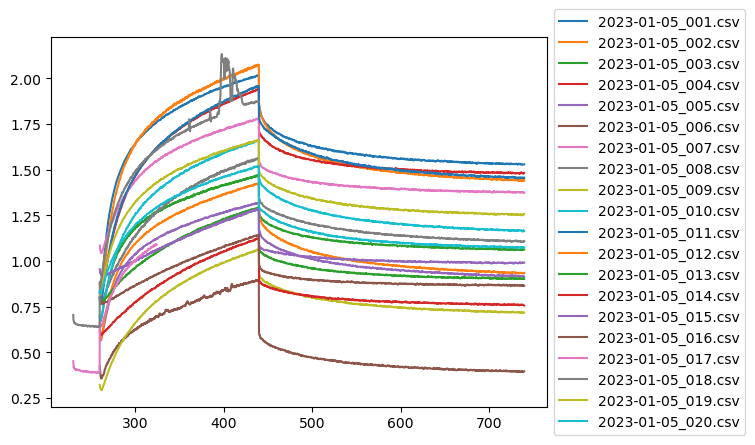

In [84]:
exp = Exp()
exp.load_bli_data(fs)
exp.plot()


Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

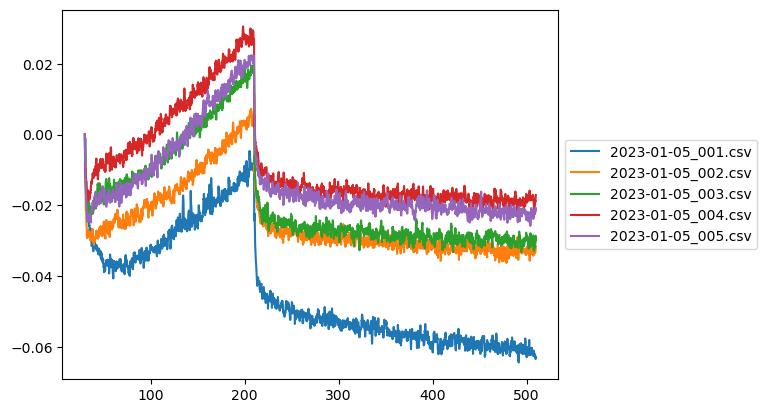

In [85]:
controls = Exp()
controls.load_bli_data(controls_fs)
controls.interstep_correction()
controls.plot()


In [86]:
str(path)

'data\\GST-D1-HLM_E3-FL_230105\\redoGST-DCP1-HLM_VS_EDC3-FL'

In [87]:
#load descriptions, need to copy from blitz
desc = Path(f"./data/GST-D1-HLM_E3-FL_230105/dataset_description.txt")
df = pd.read_csv(desc, sep='\t', index_col=0)
df

,Show,Analyze,Ref.,Sample ID,Conc. (uM),Run time (s),Shaker speed (rpm),Integration (ms),Biosensor Type,Information,Status
Index,,,,,,,,,,,
1,1,1,0,NaN,1.6,740,1000,2.0,SA,NaN,NaN
2,1,1,0,NaN,1.6,740,1000,2.1,SA,NaN,NaN
3,1,0,0,NaN,0.8,740,1000,2.0,SA,NaN,NaN
4,1,1,0,NaN,0.8,740,1000,2.0,SA,NaN,NaN
5,1,0,0,NaN,0.8,740,1000,2.0,SA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16,1,1,0,NaN,0.1,740,1000,2.0,SA,NaN,NaN
17,1,0,0,NaN,0.8,324,1000,2.2,SA,NaN,Terminated by user
18,1,0,0,NaN,0.8,440,1000,2.1,SA,NaN,Terminated by user


In [88]:
#assign concentrations from desc to each dataset
concs = df['Conc. (uM)'].to_dict()
analyze = df['Analyze'].to_dict()

for ds in exp.datasets:
    idx = ds.name[:-4].split('_')[-1]
    idx=int(idx)
    c = concs[idx]
    if np.isnan(c): c=0
    ds.steps[0].concentration = c*1e-6
    ds.use_for_fit = analyze[idx]



Dataset(0, name = 2023-01-05_001.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(1, name = 2023-01-05_002.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(2, name = 2023-01-05_003.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(3, name = 2023-01-05_004.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(4, name = 2023-01-05_005.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(5, name = 2023-01-05_006.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(6, name = 2023-01-05_007.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(7, name = 2023-01-05_008.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(8, name = 2023-01-05_009.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(9, name = 2

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

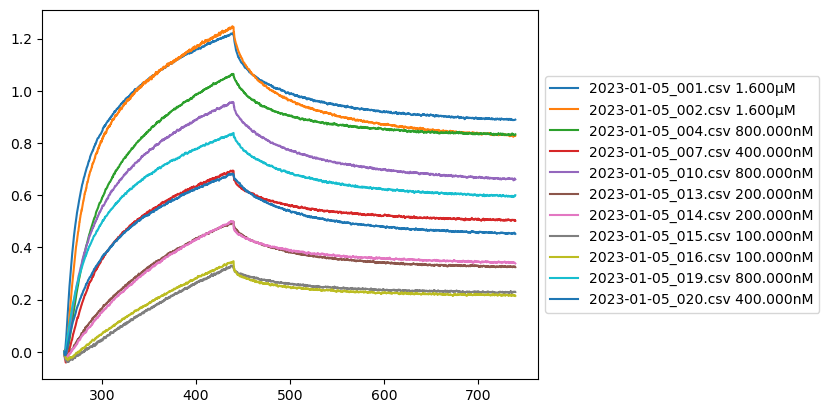

In [89]:
for ds in exp.datasets:
    print(ds)
exp.interstep_correction()
exp.plot()

In [90]:
#assign conentrations to controls
controls_c = [0.,0.2,0.4,0.8,1.6]
controls_c = [c*1e-6 for c in controls_c]

for ds, c in zip(controls, controls_c):
    ds.steps[0].concentration = c




1.6e-06
correcting c= 1.6e-06
1.6e-06
correcting c= 1.6e-06
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07
8e-07
correcting c= 8e-07
2e-07
correcting c= 2e-07
2e-07
correcting c= 2e-07
1e-07
1e-07
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07
Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

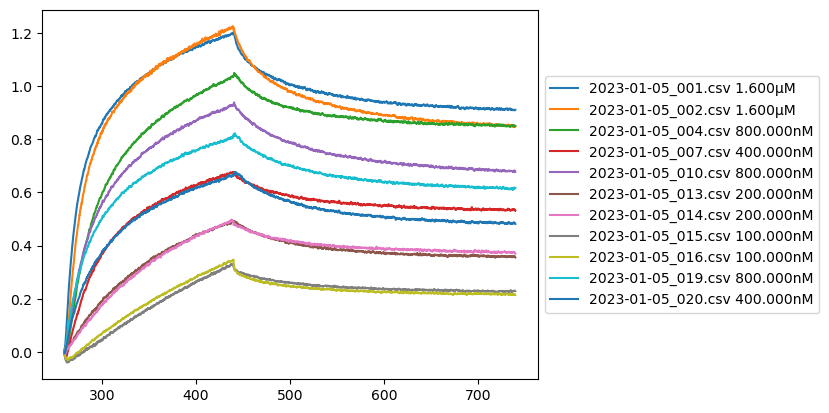

In [91]:
controls_dict = {}
for ds in controls:
    control_mask = ds.t>=ds.steps[0].start
    c = ds.steps[0].concentration
    controls_dict[c] = ds.response[control_mask]

#subtract controls from ds
for ds in exp:
    if not ds.use_for_fit: continue
    print(ds.steps[0].concentration)
    start = ds.steps[0].start
    mask = ds.t>=start
    r = ds.response[mask]
    c = ds.steps[0].concentration
    if c in controls_dict:
        print('correcting c=',c)
        ds.response[mask] = np.subtract(r, controls_dict[c])
        

exp.plot()

In [92]:
# exp.crop(3)

Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

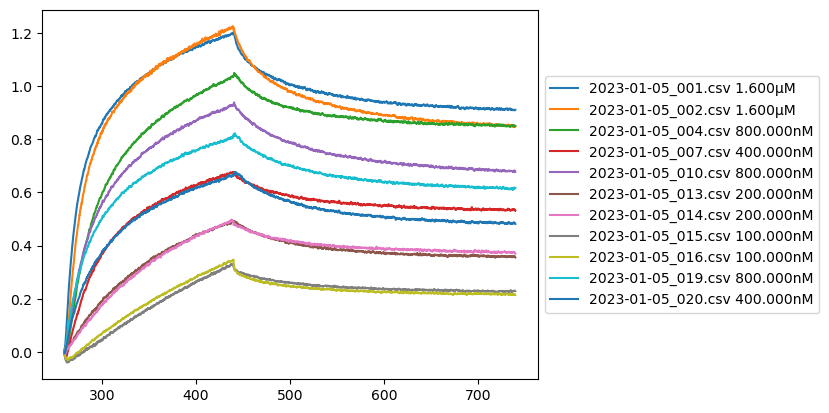

In [93]:
exp.interstep_correction()
exp.plot()

In [94]:
#remove some datasets
ds_to_remove = []
for ds in exp:
    if ds.use_for_fit == False:
        ds_to_remove.append(ds)
for ds in ds_to_remove:
    exp.datasets.remove(ds)

In [95]:
exp.model = models.Heterogeneous_ligand()
exp.model.params_definitions

{'ka1': <Parameter 'ka1', value=10000.0, bounds=[10.0:10000000.0]>,
 'kd1': <Parameter 'kd1', value=0.01, bounds=[1e-06:0.1]>,
 'ka2': <Parameter 'ka2', value=10000.0, bounds=[1e-07:10000000.0]>,
 'kd2': <Parameter 'kd2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kt': <Parameter 'kt', value=10000000.0, bounds=[10.0:1000000000000.0]>,
 'ymax1': <Parameter 'ymax1', value=1, bounds=[1e-12:1000]>,
 'ymax2': <Parameter 'ymax2', value=1, bounds=[1e-12:1000]>,
 'offset': <Parameter 'offset', value=0, bounds=[0:1000]>}

In [102]:

exp.model.params_definitions['ymax1'].user_data['type']='global'
exp.model.params_definitions['ymax2'].user_data['type']='global'

exp.create_params(offsets=1, mtl = False)



In [103]:
exp.params

name,value,initial value,min,max,vary
ka1,10000.0000,10000.0,10.0000000,10000000.0,True
kd1,0.01000000,0.01,1.0000e-06,0.10000000,True
ka2,10000.0000,10000.0,1.0000e-07,10000000.0,True
kd2,0.01000000,0.01,1.0000e-07,10000000.0,True
ymax1,1.00000000,1,1.0000e-12,1000.00000,True
ymax2,1.00000000,1,1.0000e-12,1000.00000,True
offset_ds0_step0,0.00000000,-1000,0.00000000,1000.00000,True
offset_ds0_step1,0.00000000,-1000,0.00000000,1000.00000,True
offset_ds1_step0,0.00000000,-1000,0.00000000,1000.00000,True
offset_ds1_step1,0.00000000,-1000,0.00000000,1000.00000,True


In [104]:
exp.fit_params()

fitting using: least_squares


'`ftol` termination condition is satisfied.'

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

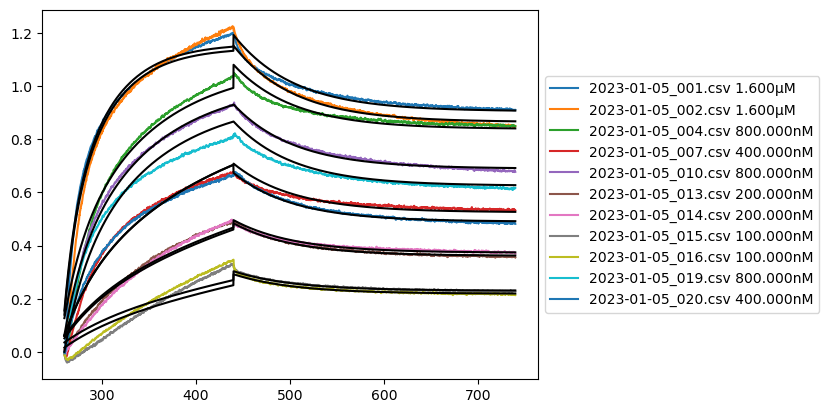

In [105]:
exp.plot(fit=1, correct_offsets=0)

In [442]:
exp.result

In [386]:
import plotly.graph_objects as go

fig = go.Figure()

for ds in exp.datasets:
    if ds.use_for_fit == False: continue
    x = np.array([])
    y = np.array([])
    y_fit = np.array([])
    
    for step in ds.steps:
        # if step.concentration>0: color = 'orangered'
        # elif step.concentration==0: color = 'cornflowerBlue'
        # else: color = 'lightgrey'
        mask = (ds.t>=step.start) & (ds.t<step.stop)

        if f"offset_ds{ds.index}_step{step.index}" in exp.params:
                offset = exp.params[f'offset_ds{ds.index}_step{step.index}'].value
        else: 
            offset = 0
        
        x_step = ds.t[mask]
        y_step = ds.response[mask] - offset
        y_fit_step = ds.fit_response[mask] - offset

        x = np.concatenate([x, x_step])
        y = np.concatenate([y, y_step])
        y_fit = np.concatenate([y_fit, y_fit_step])

    
    x = x - x[0]
    fig.add_scatter(x = x, 
                    y = y_fit,
                    marker=dict(size=0, 
                            color='black',
                            line=dict(width=1, color='black')),
                    line=dict(
                         width=2, 
                         color='black'
                         ),
                    name=ds.steps[0].concentration,)

        

    fig.add_scatter(x = x,
                    y = y,
                    marker=dict(
                            size=0, 
                            #color=color, 
                            line=dict(
                                    width=0.1, 
                                    #color=color
                                    )),
                    line=dict(
                            width=1, 
                            #color=color
                            ),
                    name=f"{ds.index}_{ds.steps[0].concentration}",
                    )



fig.update_layout(
            height=600,
            width = 800,
            font_family="Arial",
            font_size = 24,
            showlegend=False,
            margin=dict(l=0,r=0,b=0,t=0,pad=0), 
            template='plotly_white',
            paper_bgcolor="rgb(255, 255, 255)",  
            plot_bgcolor="rgb(255, 255, 255)") 

fig.update_xaxes(
    ticklabelposition="inside top", 
    title='time [s]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)

fig.update_yaxes(
    ticklabelposition="outside top", 
    title='Response [nm]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)



fig.show()

In [385]:
for ds in exp:
    if ds.index in [6, 10,11,12,5,14, 16]:
        ds.use_for_fit = False
    if ds.index in []:
        ds.use_for_fit = True
    # if ds.steps[0].concentration==16e-6:
    #     ds.use_for_fit = True



In [378]:
exp.crop(3)

In [373]:
import kaleido
exp_name = "GST-D1_E3-HLM"
fig.write_image(f'{exp_name}.png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [359]:
report_filename = 'gst-d1-hlm_e3-lsm'

from lmfit.printfuncs import fitreport_html_table
s = fitreport_html_table(exp.result, show_correl=True,  min_correl=0.1)

with open(f"{exp_name}.htm", 'w') as f:
    f.write(s)


In [363]:
from uncertainties import ufloat
def get_html_report(show_correl=True):
    result = exp.result
    tables = result._repr_html_(show_correl=show_correl)
    
    if ('ka' in result.params) and ('kd' in result.params):
        t = []
        cell = lambda x, tag: f'<{tag}> {x} </{tag}>'
        
        has_er = hasattr(result.params['ka'], 'stderr') and (result.params['ka'].stderr is not None)

        if has_er:
            ka = ufloat(float(result.params['ka'].value), float(result.params['ka'].stderr))
            kd = ufloat(float(result.params['kd'].value), float(result.params['kd'].stderr))
            Kd = kd/ka
        else:
            Kd = result.params['kd'].value/result.params['ka'].value

        t.append('<h2>Dissociation constant</h2>')
        t.append('<table><tr>')
        t.append(cell(f"<b>Name</b>", 'td'))
        t.append(cell(f"<b>value</b>", 'td'))
        t.append(cell(f"<b>standard error</b>", 'td'))
        t.append(cell(f"<b>relative error</b>", 'td'))  
        t.append('</tr><tr>')
        t.append(cell(f"<b>Kd</b>", 'td'))
        if has_er:
            t.append(cell(f"{Kd.n:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev/Kd.n:.2%}", 'td'))
        else:
            t.append(cell(f"{Kd:.5e}", 'td'))
            t.append(cell("NA", 'td'))
            t.append(cell("NA", 'td'))
        t.append('</table></tr></table>')

        return tables + ''.join(t)
    
    else: 
        return tables

report = get_html_report(show_correl=False)
with open(f'{exp_name}extended_report.htm','w') as f:
    f.write(report)

In [115]:
exp.datasets[3].steps

[Step(0, start = 180.0, stop = 300.0, len = 120.0, c = 2.4e-05, type = Association),
 Step(1, start = 300.0, stop = 420, len = 120.0, c = 0, type = Dissociation)]

In [ ]:
for p in exp.result.params:
    exp.result.params[p].stderr = abs(exp.result.params[p].value * 0.1)


In [51]:
pars = exp.result.params
p = exp.result.params['ka']
pars2 = 

In [108]:
to_remove = []
for k,v in pars2.items():
    if k not in "ka kd ymax".split(): to_remove.append(k)
for k in to_remove:
    pars2.pop(k)
pars2

name,value,standard error,relative error,initial value,min,max,vary
ka,9999.86762,999.986762,(10.00%),9999.867036401429,100.000000,100000.000,True
kd,0.03129082,0.00312908,(10.00%),0.031254614857271594,1.0000e-06,0.10000000,True
ymax,0.23326252,0.02332625,(10.00%),0.23330310680059616,1.0000e-12,1.00000000,True


In [110]:
exp.result.params = pars2
exp.params = pars2
for p in exp.result.params:
    exp.result.params[p].stderr = abs(exp.result.params[p].value * 0.1)

In [111]:
exp.params


name,value,standard error,relative error,initial value,min,max,vary
ka,9999.86762,999.986762,(10.00%),9999.867036401429,100.000000,100000.000,True
kd,0.03129082,0.00312908,(10.00%),0.031254614857271594,1.0000e-06,0.10000000,True
ymax,0.23326252,0.02332625,(10.00%),0.23330310680059616,1.0000e-12,1.00000000,True


In [112]:
exp.fit_params()
exp.result

Dataset 0 will be ommited. It does not contain any step with concentration>0.
Dataset 1 will be ommited. It does not contain any step with concentration>0.
Dataset 2 will be ommited. It does not contain any step with concentration>0.
Dataset 4 will be ommited. It does not contain any step with concentration>0.
fitting using: least_squares


In [106]:
import numpy as np

import lmfit

x = np.linspace(0.3, 10, 100)
np.random.seed(0)
y = 1/(0.1*x) + 2 + 0.1*np.random.randn(x.size)
pars = lmfit.Parameters()
pars.add_many(('a', 0.1), ('b', 1))


def residual(p):
    return 1/(p['a']*x) + p['b'] - y

mini = lmfit.Minimizer(residual, pars)
result = mini.minimize()

result.params

name,value,standard error,relative error,initial value,min,max,vary
a,0.09943896,1.9322e-04,(0.19%),0.1,-inf,inf,True
b,1.98476942,0.01222678,(0.62%),1,-inf,inf,True


In [107]:
result.message

'Fit succeeded.'